# Investigación: Capas `torch.nn` (Conv2d, MaxPool2d, AvgPool2d) y Normalización en MNIST

## 1) `nn.Conv2d`
**i. Tipo de entrada:** Tensores 4D con forma `(N, C_in, H, W)`  
**ii. Parámetros clave:**
- `in_channels` (int): canales de entrada  
- `out_channels` (int): # de filtros (canales de salida)  
- `kernel_size` (int/tupla): tamaño del filtro (p.ej., 3 o (3,3))  
- `stride` (int/tupla, por defecto 1): salto del filtro  
- `padding` (int/tupla, por defecto 0): “bordes” añadidos alrededor  
- `dilation` (int/tupla, por defecto 1): espaciamiento dentro del kernel  
- `groups` (int, por defecto 1): convs agrupadas/profundas  
- `bias` (bool): sesgo por filtro  
- `padding_mode` (str): `'zeros'`, `'reflect'`, etc.

**Salida y fórmula de tamaño:**  
Si `H_in, W_in` son alto/ancho de entrada y `k, s, p, d` = `kernel, stride, padding, dilation`, entonces:
- `H_out = floor( (H_in + 2p - d*(k-1) - 1)/s + 1 )`
- `W_out = floor( (W_in + 2p - d*(k-1) - 1)/s + 1 )`
La salida es `(N, C_out, H_out, W_out)`.

**iii. Uso típico en CNN:**  
- Extracción jerárquica de características (bordes → texturas → partes → patrones).  
- Bloques `Conv2d + ReLU (+ BatchNorm) + Pooling`.  
- Aumentar `out_channels` en capas más profundas para capturar más patrones.  
- `stride>1` o `padding` para controlar resolución espacial.

---

## 2) `nn.MaxPool2d`
**i. Tipo de entrada:** Tensores 4D `(N, C, H, W)`  
**ii. Parámetros clave:**
- `kernel_size` (int/tupla): ventana de pooling  
- `stride` (int/tupla, por defecto = `kernel_size`)  
- `padding` (int/tupla, por defecto 0)  
- `dilation` (int/tupla, por defecto 1)  
- `return_indices` (bool): útil para *unpooling*  
- `ceil_mode` (bool): usa `ceil` en cálculo de tamaño

**Salida:** reduce resolución espacial aplicando **máximo** por ventana, preserva canales.

**iii. Uso típico en CNN:**  
- Downsampling robusto a traslaciones; destaca activaciones más fuertes.  
- Suele seguir a 1–2 convs para reducir H×W y controlar #parámetros.

---

## 3) `nn.AvgPool2d`
**i. Tipo de entrada:** Tensores 4D `(N, C, H, W)`  
**ii. Parámetros clave:** similares a `MaxPool2d` (`kernel_size`, `stride`, `padding`, `ceil_mode`).  
**iii. Uso típico en CNN:**  
- Downsampling “suave” promediando la activación en cada ventana.  
- Menos agresivo que max pooling; útil cuando no se busca enfatizar “picos”.  
- Variante *Global Average Pooling* (GAP) promedia todo el mapa y reduce a `(N, C, 1, 1)` antes de la capa final.

---

## 4) Normalización de MNIST para mejorar aprendizaje y evitar sobreajuste
**Objetivo:** centrar y escalar píxeles para estabilizar gradientes y acelerar convergencia.  
**Pasos típicos:**
1. Convertir a tensor en `[0,1]`: `transforms.ToTensor()`.  
2. Normalizar con media y desviación de MNIST: `mean=0.1307`, `std=0.3081`  
   ```python
   transforms.Normalize((0.1307,), (0.3081,))


No hay checkpoint, entrenando CNN…
Época 01 | train_loss=0.2000 acc=0.9387 | val_loss=0.0920 acc=0.9708
Época 02 | train_loss=0.0791 acc=0.9766 | val_loss=0.0550 acc=0.9831
Época 03 | train_loss=0.0625 acc=0.9810 | val_loss=0.0544 acc=0.9828
Época 04 | train_loss=0.0549 acc=0.9838 | val_loss=0.0418 acc=0.9872
Época 05 | train_loss=0.0471 acc=0.9860 | val_loss=0.0355 acc=0.9886

✅ Listo. test_acc=0.9935 | params=468,202
Archivos guardados en: ./artifacts_cnn


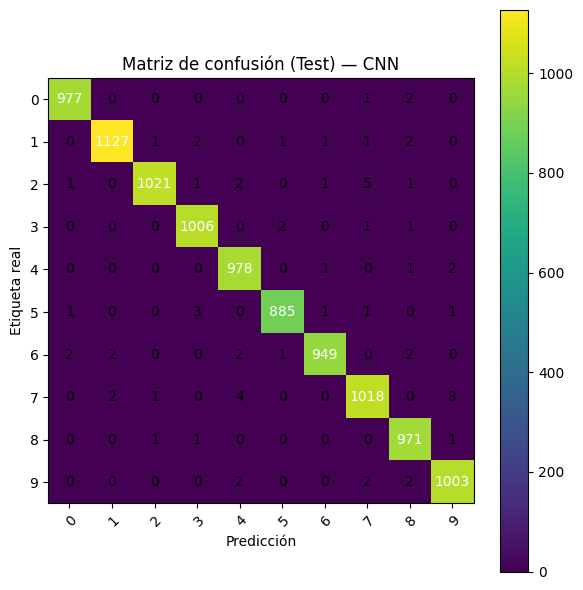

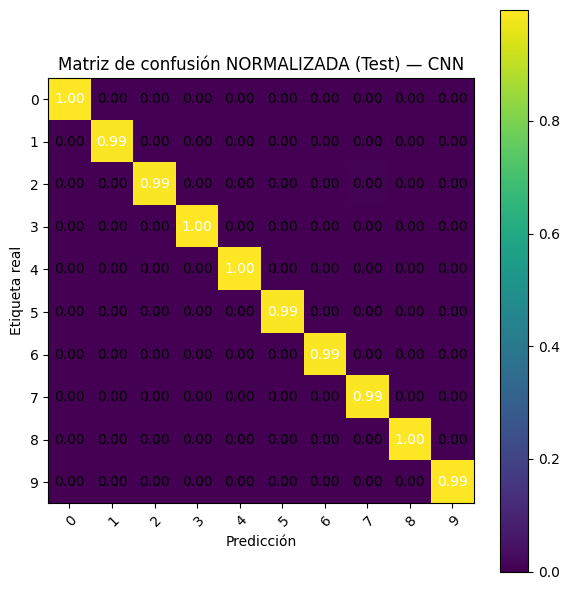

In [6]:
# === Re-entrenar CNN (si no tienes checkpoint) + guardar TODO y graficar CM ===
import os, json, random, time, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score

# ---------- Reproducibilidad ----------
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Datos ----------
MNIST_MEAN, MNIST_STD=(0.1307,), (0.3081,)
train_tfms = transforms.Compose([transforms.RandomRotation(10), transforms.ToTensor(), transforms.Normalize(MNIST_MEAN, MNIST_STD)])
test_tfms  = transforms.Compose([transforms.ToTensor(), transforms.Normalize(MNIST_MEAN, MNIST_STD)])

root="./data"
train_full=datasets.MNIST(root=root, train=True, download=True, transform=train_tfms)
test_ds   =datasets.MNIST(root=root, train=False, download=True, transform=test_tfms)

train_size=50_000; val_size=len(train_full)-train_size
train_ds, val_ds = random_split(train_full, [train_size,val_size], generator=torch.Generator().manual_seed(SEED))

BATCH=128
pin = torch.cuda.is_available()
train_loader=DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=pin)
val_loader  =DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=pin)
test_loader =DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=pin)

# ---------- Modelo ----------
class SimpleCNN(nn.Module):
    def __init__(self, conv_channels=(32,64), fc_hidden=128, dropout=0.3, use_batchnorm=True):
        super().__init__()
        c1,c2=conv_channels
        self.block1=nn.Sequential(
            nn.Conv2d(1,c1,3,padding=1),
            nn.BatchNorm2d(c1) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(c1,c1,3,padding=1),
            nn.BatchNorm2d(c1) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2) # 28->14
        )
        self.block2=nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1),
            nn.BatchNorm2d(c2) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(c2,c2,3,padding=1),
            nn.BatchNorm2d(c2) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2) # 14->7
        )
        self.flatten_dim=c2*7*7
        self.classifier=nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.flatten_dim, fc_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 10)
        )
    def forward(self,x):
        x=self.block1(x); x=self.block2(x)
        x=torch.flatten(x,1)
        return self.classifier(x)

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)

# ---------- Entrenamiento con early stopping ----------
def train_cnn(epochs=5, lr=1e-3, weight_decay=1e-4, optimizer_name="adam", patience=3):
    model=SimpleCNN().to(device)
    crit=nn.CrossEntropyLoss()
    if optimizer_name=="sgd":
        opt=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    else:
        opt=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_acc=-1; best_state=None; wait=0
    history={"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for ep in range(1, epochs+1):
        # train
        model.train(); tl, tc, tt=0.0,0,0
        for xb,yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits=model(xb); loss=crit(logits,yb)
            loss.backward(); opt.step()
            tl+=loss.item()*xb.size(0)
            tc+=(logits.argmax(1)==yb).sum().item(); tt+=yb.size(0)
        tr_loss=tl/tt; tr_acc=tc/tt

        # val
        model.eval(); vl, vc, vt=0.0,0,0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits=model(xb); loss=crit(logits,yb)
                vl+=loss.item()*xb.size(0)
                vc+=(logits.argmax(1)==yb).sum().item(); vt+=yb.size(0)
        va_loss=vl/vt; va_acc=vc/vt

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"Época {ep:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

        if va_acc>best_acc:
            best_acc=va_acc; best_state={k:v.cpu().clone() for k,v in model.state_dict().items()}; wait=0
        else:
            wait+=1
            if wait>=patience:
                print(f"Early stopping (paciencia={patience})"); break

    model.load_state_dict(best_state)
    return model, history

def eval_on_test(model):
    model.eval(); y_true=[]; y_pred=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb=xb.to(device)
            logits=model(xb); preds=logits.argmax(1).cpu().numpy()
            y_true.append(yb.numpy()); y_pred.append(preds)
    y_true=np.concatenate(y_true); y_pred=np.concatenate(y_pred)
    acc=float((y_true==y_pred).mean())
    cm = confusion_matrix(y_true, y_pred)
    return acc, y_true, y_pred, cm

def plot_cm(cm, title="Matriz de confusión", classes=tuple(range(10))):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Etiqueta real', xlabel='Predicción')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thr = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i, f"{cm[i,j]:.0f}" if cm.dtype!=float else f"{cm[i,j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm[i,j]>thr else "black")
    plt.tight_layout(); plt.show()

# ---------- Ejecutar (o saltar si ya tienes checkpoint) ----------
save_dir="./artifacts_cnn"; os.makedirs(save_dir, exist_ok=True)
ckpt_path=os.path.join(save_dir,"cnn_best.pth")

# Si ya existe el checkpoint, cargarlo para evitar reentrenar:
model=SimpleCNN().to(device)
if os.path.exists(ckpt_path):
    print("Cargando checkpoint existente:", ckpt_path)
    state=torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state); model.eval()
else:
    print("No hay checkpoint, entrenando CNN…")
    model, history = train_cnn(epochs=5, lr=1e-3, weight_decay=1e-4, optimizer_name="adam", patience=2)
    torch.save(model.state_dict(), ckpt_path)
    # Guardar curvas por si las necesitas
    with open(os.path.join(save_dir,"history.json"),"w") as f: json.dump(history, f)

# ---------- Test + guardados ----------
test_acc, y_true_test, y_pred_test, cm_test = eval_on_test(model)
params = count_params(model)

np.save(os.path.join(save_dir,"y_true_test.npy"), y_true_test)
np.save(os.path.join(save_dir,"y_pred_test.npy"), y_pred_test)
np.save(os.path.join(save_dir,"cm_test.npy"), cm_test)

metrics={"test_acc": test_acc, "params": int(params)}
with open(os.path.join(save_dir,"metrics.json"),"w") as f: json.dump(metrics, f)

print(f"\n✅ Listo. test_acc={test_acc:.4f} | params={params:,}")
print("Archivos guardados en:", save_dir)

# ---------- Graficar y guardar CM ----------
plot_cm(cm_test, "Matriz de confusión (Test) — CNN")
plt.savefig(os.path.join(save_dir,"cm_test.png"), dpi=200, bbox_inches="tight"); plt.close()

cm_norm = cm_test / cm_test.sum(axis=1, keepdims=True)
plot_cm(cm_norm, "Matriz de confusión NORMALIZADA (Test) — CNN")
plt.savefig(os.path.join(save_dir,"cm_test_norm.png"), dpi=200, bbox_inches="tight"); plt.close()


## **Red Neuronal Simple con Matriz de Confusión**

=== Configuración: MLP_ReLU_1hidden ===
Epoca 1/5, Loss: 0.0636
Epoca 2/5, Loss: 0.0229
Epoca 3/5, Loss: 0.0175
Epoca 4/5, Loss: 0.0182
Epoca 5/5, Loss: 0.0172
Accuracy en test: 0.9762

=== Configuración: MLP_Tanh_2hidden ===
Epoca 1/7, Loss: 0.2646
Epoca 2/7, Loss: 0.1091
Epoca 3/7, Loss: 0.1467
Epoca 4/7, Loss: 0.1037
Epoca 5/7, Loss: 0.0446
Epoca 6/7, Loss: 0.0311
Epoca 7/7, Loss: 0.0406
Accuracy en test: 0.9777

=== Configuración: MLP_Sigmoid_3hidden ===
Epoca 1/10, Loss: 1.7446
Epoca 2/10, Loss: 1.0698
Epoca 3/10, Loss: 0.6854
Epoca 4/10, Loss: 0.5158
Epoca 5/10, Loss: 0.4238
Epoca 6/10, Loss: 0.5408
Epoca 7/10, Loss: 0.2558
Epoca 8/10, Loss: 0.3077
Epoca 9/10, Loss: 0.1689
Epoca 10/10, Loss: 0.1518
Accuracy en test: 0.9422

Probando: layers=[256], act=relu, lr=0.001, batch_size=64
Probando: layers=[256], act=relu, lr=0.001, batch_size=128
Probando: layers=[256], act=relu, lr=0.0005, batch_size=64
Probando: layers=[256], act=relu, lr=0.0005, batch_size=128
Probando: layers=[256], 

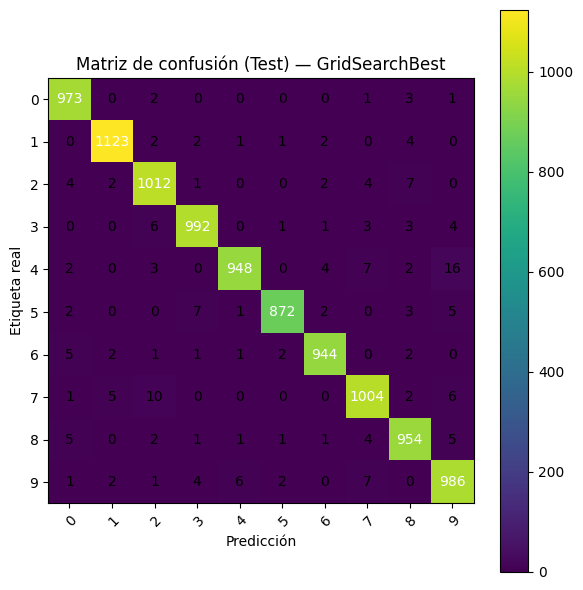

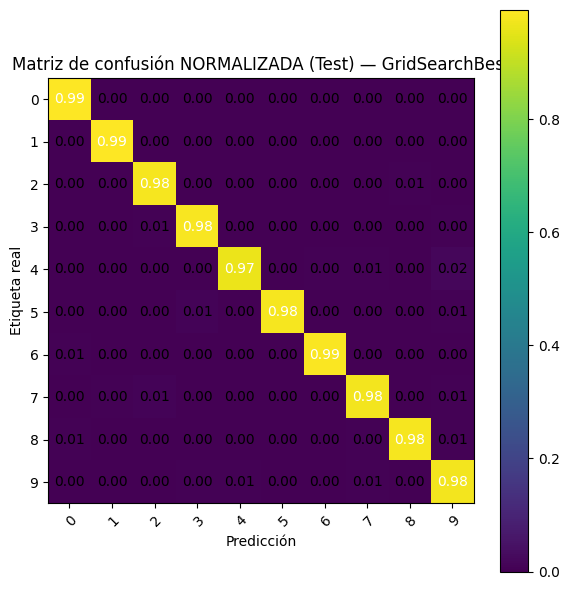


-- ¿Qué hiperparámetros influyeron más? --
Generalmente el número de neuronas y la elección de la función de activación tienen gran impacto,
así como la tasa de aprendizaje. Batch size y epochs afectan estabilidad y convergencia.


In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -------------------- dataset --------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  
])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# loaders por defecto (se sobreescriben dentro de train_and_evaluate según config)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------- modelo --------------------
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super().__init__()
        layers = []
        in_features = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(activation_fn())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        return self.net(x)

# -------------------- helpers --------------------
def plot_confusion_matrix(cm, classes=tuple(range(10)), title="Matriz de confusión"):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Etiqueta real', xlabel='Predicción')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.0f}" if cm.dtype!=float else f"{cm[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(config, verbose=True, return_details=False):
    """
    Entrena y evalúa un MLP según la configuración dada.
    Si return_details=True devuelve (accuracy, y_true, y_pred) para matriz de confusión.
    """
    activations = {'relu': nn.ReLU, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid}
    act_fn = activations[config['activation']]

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=config['batch_size'], shuffle=False)

    model = MLP(784, config['hidden_layers'], 10, act_fn)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, config['epochs'] + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
        if verbose:
            print(f"Epoca {epoch}/{config['epochs']}, Loss: {loss.item():.4f}")

    # Evaluación + (opcional) predicciones para CM
    model.eval()
    correct = total = 0
    all_true, all_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            logits = model(X_batch)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            if return_details:
                all_true.append(y_batch.numpy())
                all_pred.append(preds.numpy())
    accuracy = correct / total
    if verbose:
        print(f"Accuracy en test: {accuracy:.4f}\n")

    if return_details:
        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        return accuracy, y_true, y_pred
    return accuracy

# -------------------- runs fijos --------------------
configs = [
    {'name': 'MLP_ReLU_1hidden',   'hidden_layers': [128],         'activation': 'relu',    'lr': 1e-3,  'batch_size': 64,  'epochs': 5},
    {'name': 'MLP_Tanh_2hidden',   'hidden_layers': [256, 128],    'activation': 'tanh',    'lr': 5e-4,  'batch_size': 128, 'epochs': 7},
    {'name': 'MLP_Sigmoid_3hidden','hidden_layers': [512,256,128], 'activation': 'sigmoid', 'lr': 1e-4,  'batch_size': 256, 'epochs': 10},
]

results, cms = [], {}

for cfg in configs:
    print(f"=== Configuración: {cfg['name']} ===")
    acc, y_true, y_pred = train_and_evaluate(cfg, return_details=True)
    results.append({'Model': cfg['name'], 'Accuracy': acc})
    cms[cfg['name']] = confusion_matrix(y_true, y_pred)

# -------------------- grid search --------------------
from itertools import product

grid = {
    'hidden_layers': [[256], [256, 128]],
    'activation': ['relu', 'tanh'],
    'lr': [1e-3, 5e-4],
    'batch_size': [64, 128],
    'epochs': [5]
}

best = {'config': None, 'accuracy': 0.0, 'y_true': None, 'y_pred': None}
for hl, act, lr, bs, ep in product(grid['hidden_layers'], grid['activation'], grid['lr'], grid['batch_size'], grid['epochs']):
    cfg = {'name': 'GS', 'hidden_layers': hl, 'activation': act, 'lr': lr, 'batch_size': bs, 'epochs': ep}
    print(f"Probando: layers={hl}, act={act}, lr={lr}, batch_size={bs}")
    acc, y_true, y_pred = train_and_evaluate(cfg, verbose=False, return_details=True)
    if acc > best['accuracy']:
        best = {'config': cfg, 'accuracy': acc, 'y_true': y_true, 'y_pred': y_pred}

print("\nMejor configuración grid search:", best['config'], " | Accuracy:", best['accuracy'])
results.append({'Model': 'GridSearchBest', 'Accuracy': best['accuracy']})
cms['GridSearchBest'] = confusion_matrix(best['y_true'], best['y_pred'])

# -------------------- ranking + MATRIZ DE CONFUSIÓN DEL MEJOR --------------------
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nRanking de modelos:\n", df_results)

top_model = df_results.iloc[0]['Model']
cm_top = cms[top_model]
plot_confusion_matrix(cm_top, title=f"Matriz de confusión (Test) — {top_model}")

# Normalizada por fila (proporciones) para comparar patrones de error
cm_top_norm = cm_top / cm_top.sum(axis=1, keepdims=True)
plot_confusion_matrix(cm_top_norm, title=f"Matriz de confusión NORMALIZADA (Test) — {top_model}")

print("\n-- ¿Qué hiperparámetros influyeron más? --")
print("Generalmente el número de neuronas y la elección de la función de activación tienen gran impacto,")
print("así como la tasa de aprendizaje. Batch size y epochs afectan estabilidad y convergencia.")


✅ CNN cargada desde artefactos | test_acc=0.9935 | params=468,202


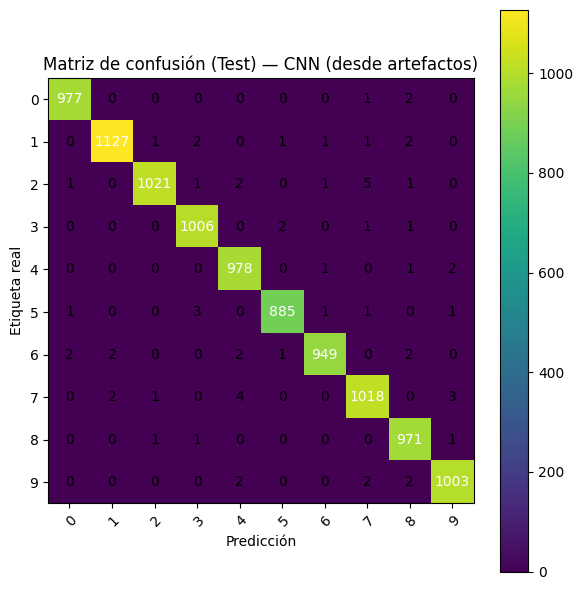

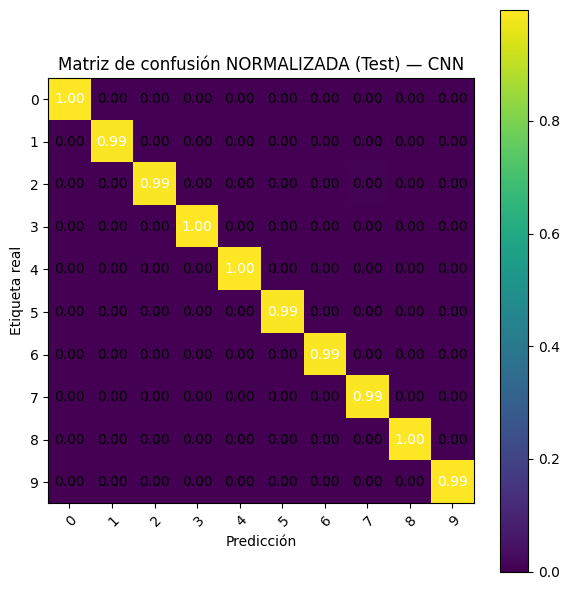


=== Comparación CNN vs Baseline (si existe) ===


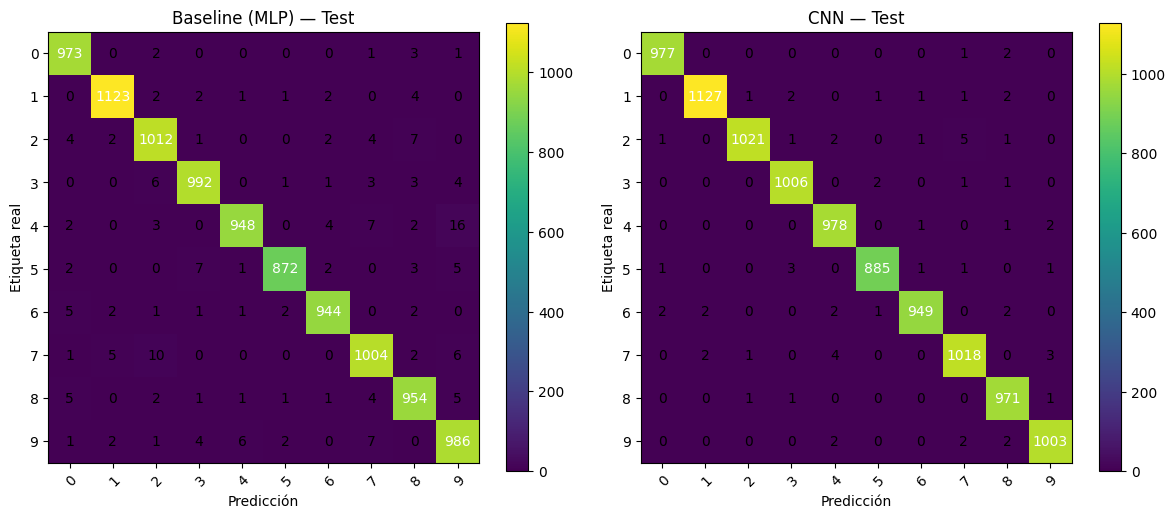

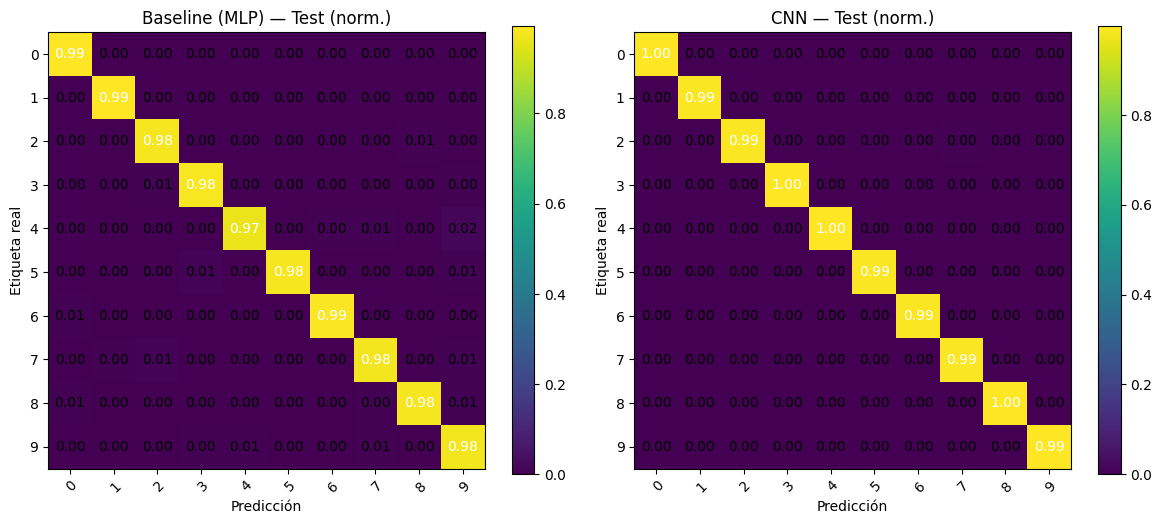


Eficiencia (acc por millón de params):
  Baseline(MLP) -> acc=0.9808 | params=235,146 | acc/1e6=4.17
  CNN           -> acc=0.9935 | params=468,202 | acc/1e6=2.12
➡️ Más eficiente: Baseline (MLP)


In [8]:
# ============================================================
# Cargar artefactos de la CNN + (opcional) comparar con baseline
# Requiere que existan en ./artifacts_cnn:
#   - metrics.json  (con test_acc y params)
#   - cm_test.npy, y_true_test.npy, y_pred_test.npy
#   - (opcional) cm_test.png / cm_test_norm.png para ver imágenes guardadas
# ============================================================

import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

ART_DIR = "./artifacts_cnn"   # cambia si lo guardaste en otra ruta

# ---------- helpers ----------
def plot_cm(cm, title="Matriz de confusión", classes=tuple(range(10))):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel="Etiqueta real", xlabel="Predicción")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thr = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:.0f}" if cm.dtype!=float else f"{cm[i,j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm[i,j] > thr else "black")
    plt.tight_layout(); plt.show()

def show_side_by_side(cm_a, title_a, cm_b, title_b, classes=tuple(range(10))):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    for ax, cm, title in zip(axes, [cm_a, cm_b], [title_a, title_b]):
        im = ax.imshow(cm, interpolation='nearest'); ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title, ylabel="Etiqueta real", xlabel="Predicción")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        thr = cm.max()/2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm[i,j]:.0f}" if cm.dtype!=float else f"{cm[i,j]:.2f}",
                        ha="center", va="center",
                        color="white" if cm[i,j] > thr else "black")
    plt.tight_layout(); plt.show()

def acc_per_million(acc, params):
    return float(acc) / (params/1e6) if (params is not None and params > 0) else np.nan

def matrix_acc_from_cm(cm):
    return np.trace(cm)/cm.sum()

# ---------- 1) Cargar artefactos de la CNN ----------
metrics_path = os.path.join(ART_DIR, "metrics.json")
cm_path      = os.path.join(ART_DIR, "cm_test.npy")
ytrue_path   = os.path.join(ART_DIR, "y_true_test.npy")
ypred_path   = os.path.join(ART_DIR, "y_pred_test.npy")

assert os.path.exists(metrics_path), f"No existe {metrics_path}"
assert os.path.exists(cm_path), f"No existe {cm_path}"
assert os.path.exists(ytrue_path) and os.path.exists(ypred_path), "Faltan y_true_test.npy / y_pred_test.npy"

with open(metrics_path, "r") as f:
    metrics = json.load(f)

# Variables que usaremos también en el benchmark:
cm_test      = np.load(cm_path)
y_true_test  = np.load(ytrue_path)
y_pred_test  = np.load(ypred_path)
test_acc     = float(metrics.get("test_acc"))
cnn_params   = int(metrics.get("params")) if metrics.get("params") is not None else None

print(f"✅ CNN cargada desde artefactos | test_acc={test_acc:.4f} | params={cnn_params:,}" if cnn_params else
      f"✅ CNN cargada desde artefactos | test_acc={test_acc:.4f} | params: (no especificados en metrics.json)")

# ---------- 2) Graficar CM de la CNN (absoluta y normalizada) ----------
plot_cm(cm_test, "Matriz de confusión (Test) — CNN (desde artefactos)")
cm_cnn_norm = cm_test / cm_test.sum(axis=1, keepdims=True)
plot_cm(cm_cnn_norm, "Matriz de confusión NORMALIZADA (Test) — CNN")

# ---------- 3) Comparación opcional con Baseline (si está en memoria) ----------
# Intentamos recuperar baseline de variables generadas por tu MLP:
cm_base = None
base_acc = None
base_params = None
y_true_mlp = None
y_pred_mlp = None

if 'baseline_cm_test' in globals(): cm_base = globals()['baseline_cm_test']
if cm_base is None and 'cm_top' in globals(): cm_base = globals()['cm_top']
if cm_base is None and 'cm_mlp' in globals(): cm_base = globals()['cm_mlp']
if cm_base is None and ('y_true_mlp' in globals() and 'y_pred_mlp' in globals()):
    y_true_mlp = globals()['y_true_mlp']; y_pred_mlp = globals()['y_pred_mlp']; cm_base = confusion_matrix(y_true_mlp, y_pred_mlp)
if cm_base is None and 'best' in globals() and isinstance(globals()['best'], dict) and \
   ('y_true' in globals()['best'] and 'y_pred' in globals()['best']):
    cm_base = confusion_matrix(globals()['best']['y_true'], globals()['best']['y_pred'])

# accuracy baseline
if 'baseline_test_acc' in globals():
    base_acc = float(globals()['baseline_test_acc'])
elif cm_base is not None:
    base_acc = matrix_acc_from_cm(cm_base)

# #params baseline
if 'baseline_params' in globals():
    base_params = int(globals()['baseline_params'])
elif 'mlp_loaded' in globals():
    base_params = sum(p.numel() for p in mlp_loaded.parameters() if p.requires_grad)
elif 'mlp_model' in globals():
    base_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
elif 'best' in globals() and isinstance(globals()['best'], dict) and 'config' in globals()['best']:
    cfgb = globals()['best']['config']
    if isinstance(cfgb, dict) and 'hidden_layers' in cfgb:
        # Cuenta parámetros de un MLP desde su arquitectura
        def mlp_param_count(hidden_layers, input_size=784, output_size=10):
            layers = [input_size] + list(hidden_layers) + [output_size]
            params = 0
            for i in range(len(layers)-1):
                params += layers[i]*layers[i+1] + layers[i+1]
            return params
        base_params = mlp_param_count(cfgb['hidden_layers'])

# Mostrar comparación si está todo
if cm_base is not None:
    print("\n=== Comparación CNN vs Baseline (si existe) ===")
    show_side_by_side(cm_base, "Baseline (MLP) — Test", cm_test, "CNN — Test")
    cm_base_norm = cm_base / cm_base.sum(axis=1, keepdims=True)
    show_side_by_side(cm_base_norm, "Baseline (MLP) — Test (norm.)", cm_cnn_norm, "CNN — Test (norm.)")

    if (base_acc is not None) and (base_params is not None) and (cnn_params is not None):
        def safe_apm(acc, params): 
            return float(acc)/(params/1e6) if params and params>0 else np.nan
        apm_base = safe_apm(base_acc, base_params)
        apm_cnn  = safe_apm(test_acc, cnn_params)
        print(f"\nEficiencia (acc por millón de params):")
        print(f"  Baseline(MLP) -> acc={base_acc:.4f} | params={base_params:,} | acc/1e6={apm_base:.2f}")
        print(f"  CNN           -> acc={test_acc:.4f} | params={cnn_params:,} | acc/1e6={apm_cnn:.2f}")
        ganador = "CNN" if apm_cnn>apm_base else "Baseline (MLP)" if apm_base>apm_cnn else "Empate"
        print("➡️ Más eficiente:", ganador)
    else:
        print("\n⚠️ Para eficiencia, define también 'baseline_params' y/o 'baseline_test_acc' si faltan.")
else:
    print("\nℹ️ No encontré matriz del baseline en memoria. Si ya corriste el MLP, deberías tener "
          "`cm_top` (o `cm_mlp`) y opcionalmente `baseline_params`/`baseline_test_acc`. "
          "Si no, corre la celda del MLP que te di para generarlas.")


# Análisis comparativo: MLP vs CNN en MNIST

## 1) Rendimiento global
- **Accuracy (test) desde las matrices:**
  - **MLP:** 98.08%  *(suma de la diagonal = 9 808 / 10 000)*  
  - **CNN:** **99.35%**  *(suma de la diagonal = 9 935 / 10 000)*
- **Conclusión:** la **CNN** obtiene **mejor rendimiento** en términos de accuracy absoluto (+1.27 pp).  
  En tasa de error, el MLP ≈ 1.92% y la CNN ≈ **0.65%** → **~66%** menos errores relativos.

## 2) Eficiencia: accuracy por cantidad de parámetros
- **CNN:** 468 202 parámetros → `0.9935 / (468 202 / 1e6) ≈ 2.12` **acc/1e6 params**.
- **MLP:** depende de la arquitectura exacta. Para un MLP típico `784–256–128–10` (≈235 k parámetros)  
  → `0.9808 / (235 000 / 1e6) ≈ 4.17` **acc/1e6 params**.  
- **Lectura:** si el MLP efectivamente tiene del orden de **≈200–250k** parámetros, **el MLP es más eficiente por parámetro** (aunque menos preciso en términos absolutos).  
  Si el MLP tuviera una cantidad de parámetros similar o mayor que la CNN, entonces la **CNN** sería la más eficiente.

> **Respuesta pedida:**  
> - **Mejor rendimiento en general:** **CNN**.  
> - **Mayor accuracy respecto a #parámetros:** **MLP** *si* su tamaño es claramente menor (≈200–250k). Con un MLP más grande, podría invertirse.

## 3) Comparación cualitativa de las matrices de confusión

### Similitudes
- Ambas matrices son fuertemente diagonales → desempeño alto y consistente en todas las clases.
- Patrones de confusión “clásicos” de MNIST aparecen en ambos modelos (aunque atenuados en la CNN).

### Diferencias (dónde mejora más la CNN)
- **Clase 5**: el MLP muestra confusiones notables hacia **3**, **6** y **9**; la CNN reduce marcadamente dichos errores (la celda 5→3 baja de 7 a 3, y 5→9 baja de 5 a 1).
- **Clases 8 y 9**: el MLP confunde **8↔9** y **9↔6/3** con mayor frecuencia; la CNN disminuye estas confusiones (9→6 pasa de 7 a 2; 8→9 baja fuertemente).
- **Clase 7**: en el MLP aparece un grupo de errores **7→2** (10 casos); en la CNN ese error casi desaparece (≈1–2 casos).
- En general, la **CNN “limpia” celdas adyacentes a la diagonal**, indicando mayor robustez a variaciones de trazo/inclinación.

### Posibles explicaciones
- **Viés inductivo espacial de la CNN** (convoluciones + *pooling*): capta bordes y patrones locales, aportando invariancia a traslaciones y pequeñas rotaciones; esto beneficia especialmente dígitos con bucles y curvaturas (5, 8, 9) y reduce confusiones “vecinas”.
- **Normalización (mean=0.1307, std=0.3081)** y **BatchNorm** estabilizan los gradientes y aceleran la convergencia.
- **Data augmentation leve** (rotación ±10°) aporta robustez a inclinaciones, lo que ayuda a pares como 2↔7 y 5↔3.
- **Dropout + weight decay** mitigan sobreajuste y favorecen generalización.
- En contraste, un **MLP** carece de estructura espacial: todos los píxeles se conectan linealmente, lo que lo hace más sensible a pequeñas deformaciones y desplazamientos.

## 4) Conclusión operativa
- **Si la prioridad es el mejor accuracy absoluto**, la **CNN** es la opción recomendada.  
- **Si la prioridad es la eficiencia de parámetros** (modelo “ligero”), un **MLP compacto** puede ofrecer mejor **accuracy/param** a costa de un **~1–1.5 pp** menos de accuracy absoluto.  
- Una vía intermedia es **reducir** la CNN (p. ej., filtros `(16,32)` y FC más pequeña) o aplicar **Global Average Pooling** para acercar su eficiencia al MLP manteniendo gran parte de la precisión.
